In [20]:
import simple_id
import torch
import os
import time
import gensim
import sys


from helpers import *

Previous work: [http://lstm.seas.harvard.edu/client/index.html](http://lstm.seas.harvard.edu/client/index.html)

Current interfaces:

[Word2Vec visual](http://shiny.reidmcy.com/int/)

[Records inspector](http://shiny.reidmcy.com/ntg/)

# Setting up enviroment

In [21]:
w2v = gensim.models.word2vec.Word2Vec.load('w2v/w2v.bin')
Net = torch.load(modelFname).cuda()

In [22]:
df_sample = pandas.read_csv('data/Other social sciences.csv', error_bad_lines = False)
df_sample.index = df_sample['wos_id']

# Picking example record

In [23]:
row = df_sample.loc['WOS:000206783400002']

In [24]:
row_dict = dict(row)
row_dict['title_tokens'] = Tokens[row_dict['wos_id']][0]
row_dict['abstract_tokens'] = Tokens[row_dict['wos_id']][1]


row_dict['title_vecs'] = simple_id.genVecSeq(row_dict['title_tokens'], w2v)
row_dict['abstract_vecs'] = simple_id.genVecSeq(row_dict['abstract_tokens'], w2v)
row_dict['class'] = 1

In [25]:
predictionDict = Net.predictRow(row_dict)
predictionDict['wos_id'] = row['wos_id']
predictionDict['title'] = row['title']

In [26]:
predictionDict

{'weightP': tensor(1.1389, device='cuda:0'),
 'weightN': tensor(-0.9029, device='cuda:0'),
 'probPos': tensor(0.9645),
 'probNeg': tensor(0.1149),
 'prediction': 1,
 'wos_id': 'WOS:000206783400002',
 'title': 'An Agent-Based Spatially Explicit Epidemiological Model in MASON'}

# Activations Visualized

(<Figure size 1440x1080 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ae930d9b0>)

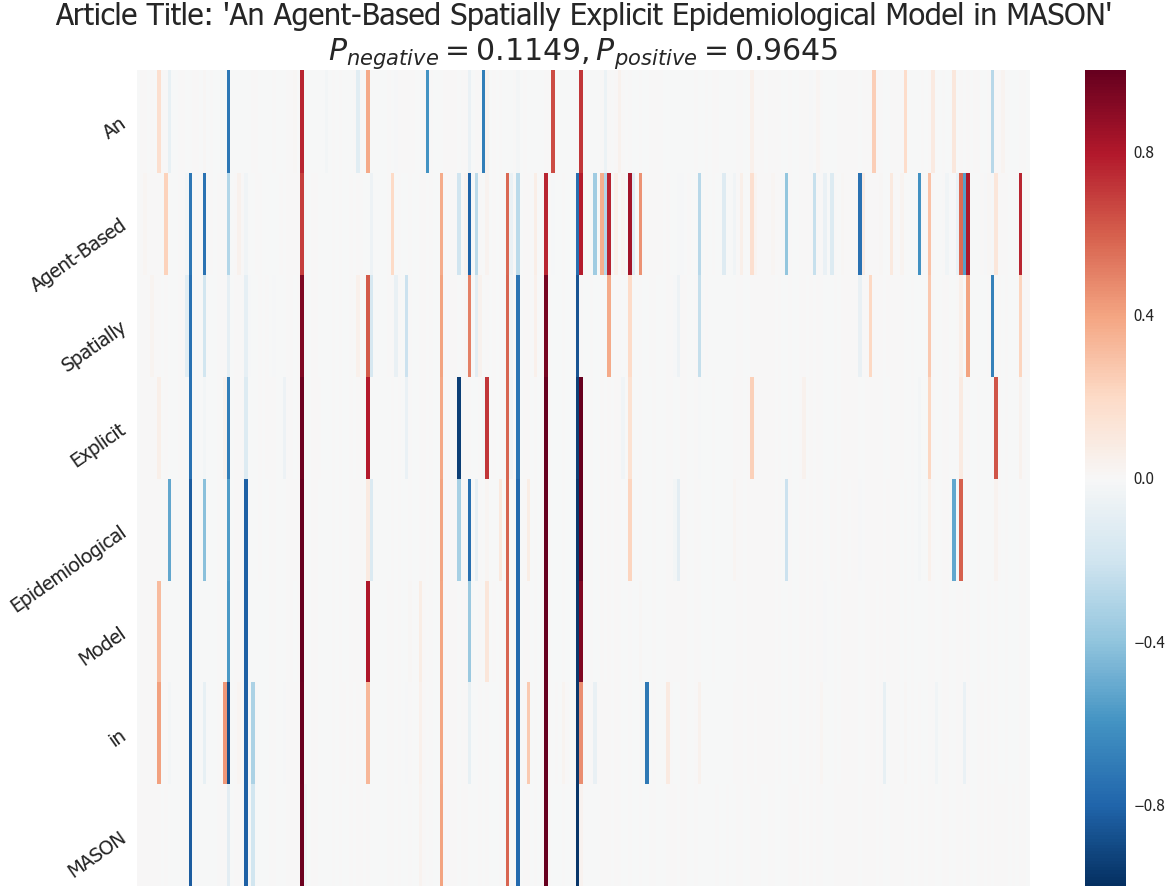

In [27]:
simple_id.compareRows([row_dict], Net)

In [28]:
row_dict['title_tokens']

['an',
 'agent-based',
 'spatially',
 'explicit',
 'epidemiological',
 'model',
 'in',
 'mason']

# Effects of varying input

In [29]:
for i in range(len(row_dict['title_tokens'])):
    newDict = {
    'abstract' : row_dict['abstract'],
    'abstract_tokens' : row_dict['abstract_tokens'],
    #'title' : row_dict['title'],
    'title_tokens' : row_dict['title_tokens'][:i + 1],   
    }
    pred = Net.predictRow(newDict, w2v=w2v)
    print("propP is: {:.2f}% with title: '{}'".format(pred['probPos'] * 100, ' '.join(newDict['title_tokens'])))

propP is: 74.44% with title: 'an'
propP is: 97.52% with title: 'an agent-based'
propP is: 96.79% with title: 'an agent-based spatially'
propP is: 97.15% with title: 'an agent-based spatially explicit'
propP is: 96.01% with title: 'an agent-based spatially explicit epidemiological'
propP is: 96.46% with title: 'an agent-based spatially explicit epidemiological model'
propP is: 97.00% with title: 'an agent-based spatially explicit epidemiological model in'
propP is: 96.45% with title: 'an agent-based spatially explicit epidemiological model in mason'


In [30]:
for i in range(len(row_dict['abstract_tokens'])):
    newDict = {
    'abstract' : row_dict['abstract'],
    'abstract_tokens' : row_dict['abstract_tokens'][:i + 1],
    'title' : row_dict['title'],
    'title_tokens' : row_dict['title_tokens'],   
    }
    pred = Net.predictRow(newDict, w2v=w2v)
    print("propP is: {:.2f}% with abstract only {} sentences long".format(pred['probPos'] * 100, i + 1))

propP is: 95.96% with abstract only 1 sentences long
propP is: 95.39% with abstract only 2 sentences long
propP is: 94.61% with abstract only 3 sentences long
propP is: 96.45% with abstract only 4 sentences long


In [31]:
preds = []
for i in range(len(row_dict['title_tokens'])):
    predT = []
    for j in range(len(row_dict['abstract_tokens'])):
        newDict = {
            'abstract_tokens' : row_dict['abstract_tokens'][:j+1],
            'title_tokens' : row_dict['title_tokens'][:i + 1],   
            }
        pred = Net.predictRow(newDict, w2v=w2v)
        predT.append(float(pred['probPos']))
    preds.append(predT)

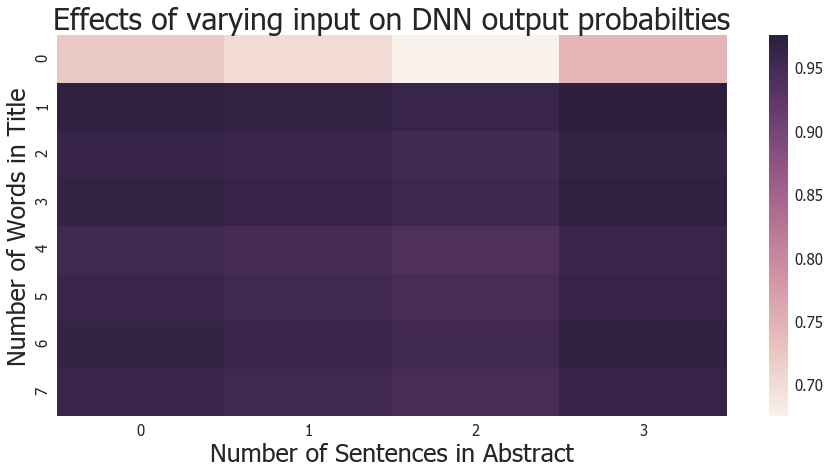

In [32]:
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(preds, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_title("Effects of varying input on DNN output probabilties");

In [33]:
preds = []
for i in range(len(row_dict['title_tokens'])):
    predT = []
    for j in range(len(row_dict['abstract_tokens'])):
        for k in range(len(row_dict['abstract_tokens'][j])):
            newDict = {
                'abstract_tokens' : row_dict['abstract_tokens'][:j] + [row_dict['abstract_tokens'][j][:k+1]],
                'title_tokens' : row_dict['title_tokens'][:i + 1],   
                }
            pred = Net.predictRow(newDict, w2v=w2v)
            predT.append(float(pred['probPos']))
    print("{:.0f}% done".format(i / len(row_dict['title_tokens']) * 100), end = '\r')
    preds.append(predT)

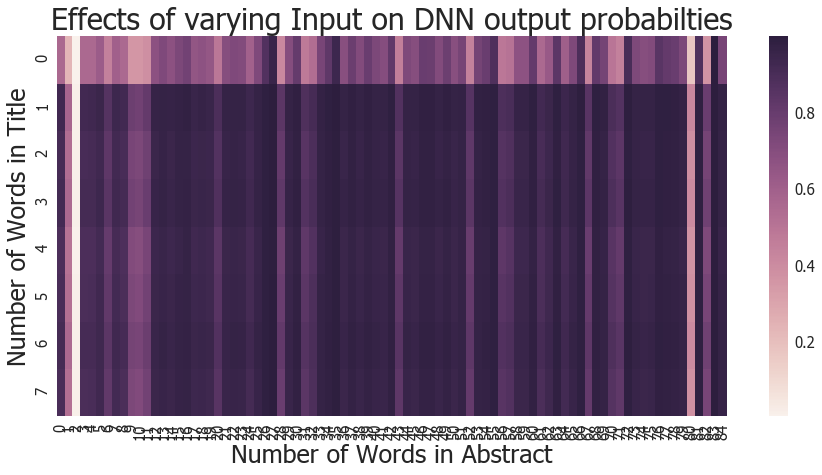

In [34]:
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(preds, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Words in Abstract')
ax.set_title("Effects of varying Input on DNN output probabilties");

# Interactive Mode Example

In [49]:
title = "Exploration of computers, tech and R"
title2 = "Effects of input elaboration on vocabulary acquisition through reading by Korean learners of English as a foreign language"
abstract = 'We used R and Python to do stuff. Then we did more stuff. Our code can be found on Github'
abstract2 = """This article investigates whether (a) lexical elaboration (LE), typographical enhancement (TE), or a combination, and (b) explicit OF implicit,LE affect 297 Korean learner's acquisition of English vocabulary. The learners were asked to read one of six versions of an experimental text that contained 26 target words. The study adopted a 2 X 3 MANOVA (:design with TE and LE as two independent variables and form- and meaning-recognition vocabulary posttests as two dependent variables. The TE had two levels, enhanced and unenhanced, and the LE lipid three levels, explicit, implicit, and unelaborated. The results were (a) LE alone did not aid form recognition of vocabulary, (b) explicit LE alone aided meaning recognition of vocabulary, (c) TE alone did not aid form and meaning recognition of vocabulary, (d) LE and TE combined did not aid form recognition of vocabulary, (e) both explicit and implicit LE aided meaning recognition of vocabulary, (f) explicit and implicit LE (lid riot differ in their effect on form and meaning recognition of vocabulary, and (g) whether a text was further enhanced in addition to either explicit or implicit LE did not seem to affect the acquisition of the previously Unknown words' forms or meanings."""

In [50]:
exampleDict = {
    'title_tokens' : simple_id.tokenizer(title),
    'abstract_tokens' : simple_id.sentinizer(abstract),   
    }
pred = Net.predictRow(newDict, w2v=w2v)
print(float(pred['probPos']))

0.9645236134529114


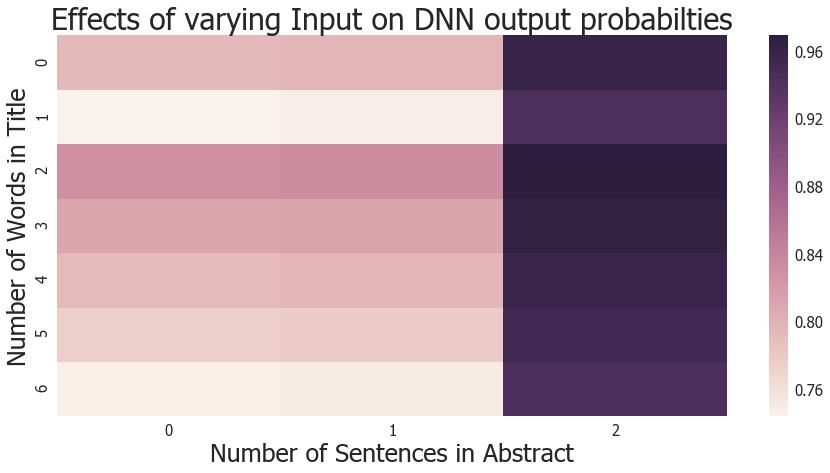

In [51]:
predA = makeVaryingArray(exampleDict, Net, w2v)
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(predA, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_title("Effects of varying Input on DNN output probabilties");

In [52]:
exampleDict = {
    'title_tokens' : simple_id.tokenizer(title2),
    'abstract_tokens' : simple_id.sentinizer(abstract2),   
    }
pred = Net.predictRow(exampleDict, w2v=w2v)
print(float(pred['probPos']))

0.14624139666557312


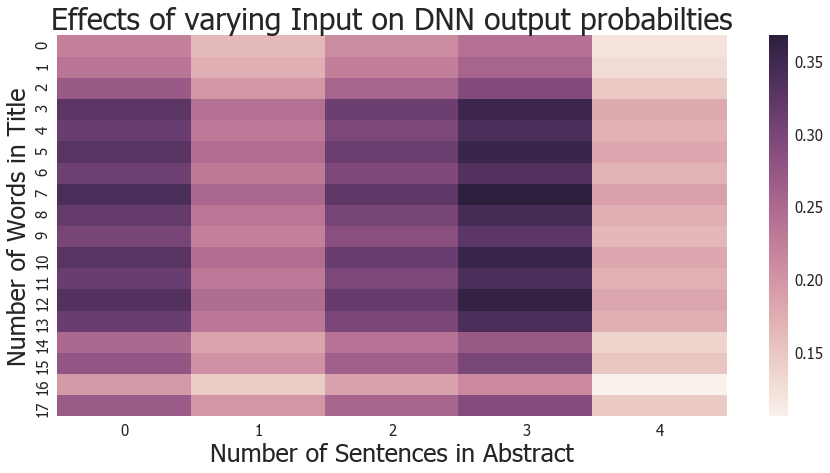

In [53]:
predA = makeVaryingArray(exampleDict, Net, w2v)
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(predA, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_title("Effects of varying Input on DNN output probabilties");

In [62]:
exampleDict = {
    'title_tokens' : simple_id.tokenizer(title2),
    'abstract_tokens' : simple_id.sentinizer(abstract2 + ' Computer github code model python R C software simulation'),   
    }
pred = Net.predictRow(exampleDict, w2v=w2v)
print(float(pred['probPos']))

0.6923291087150574


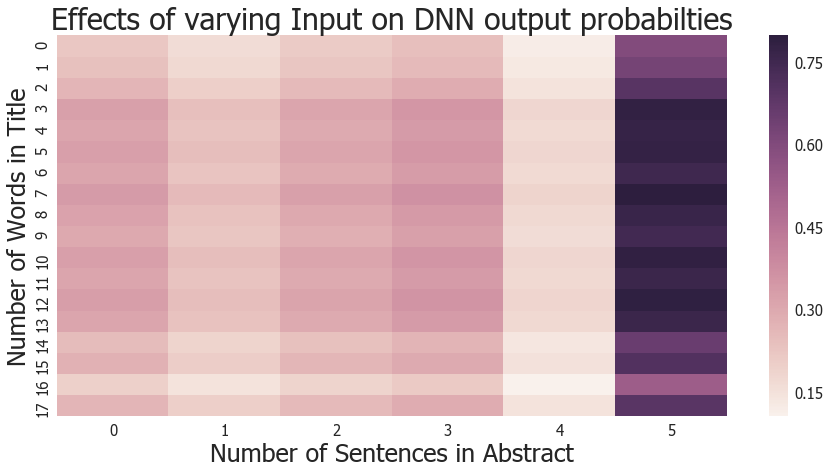

In [63]:
predA = makeVaryingArray(exampleDict, Net, w2v)
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(predA, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_title("Effects of varying Input on DNN output probabilties");

# Making the images for a bunch of examples

An Agent-Based Spatially Explicit Epidemiological Model in MASON
On the Simulation of Global Reputation Systems
Simulating the Emergence of Task Rotation
The AtollGame Experience: from Knowledge Engineering to a Computer-Assisted Role Playing Game
Uncertainty and Cooperation: Analytical Results and a Simulated Agent Society
Emancipation or workability? Critical versus pragmatic scientific orientation in action research
Speaking for ourselves A Colombia-Canada research collaboration
Active research towards the addressal of HIV/AIDS in the informal economy in Zambia Recognition of complicity in unfolding situations
Research for change Outcome mapping's contribution to emancipatory action research in Africa
Action research and social development in China Creating synergy between marginalized populations and government officials


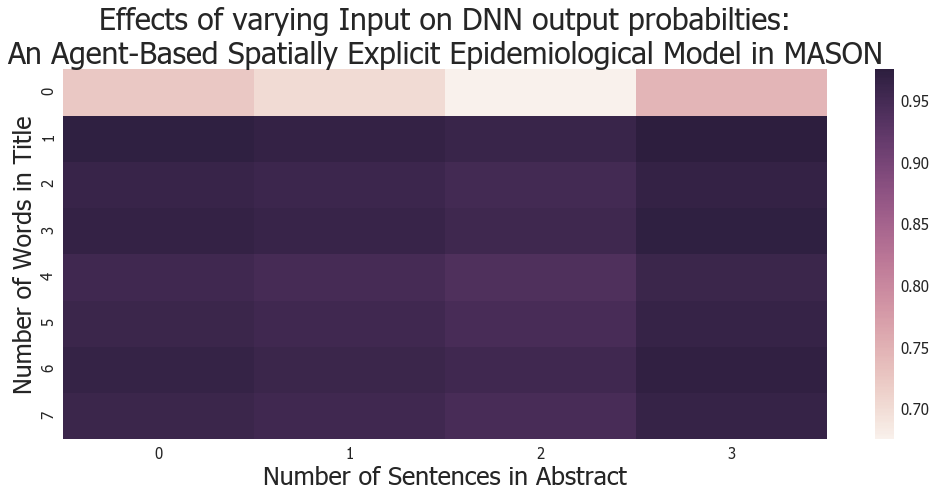

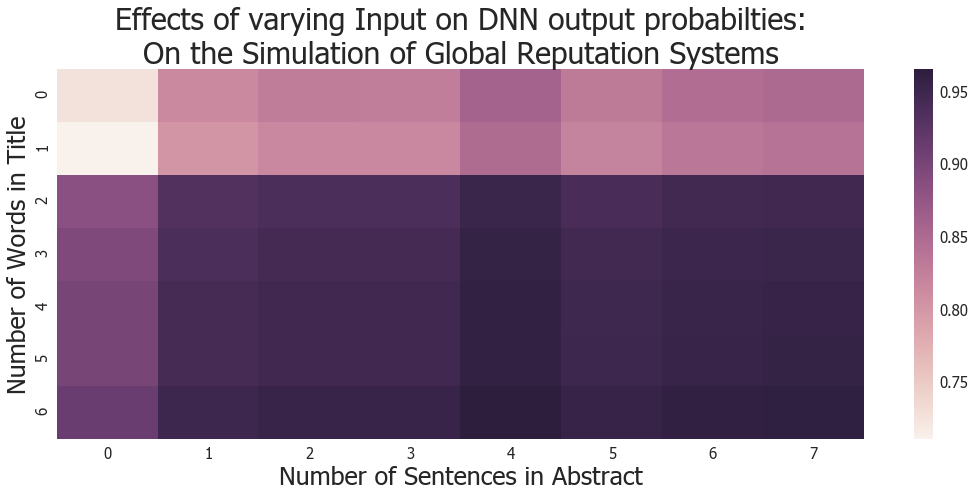

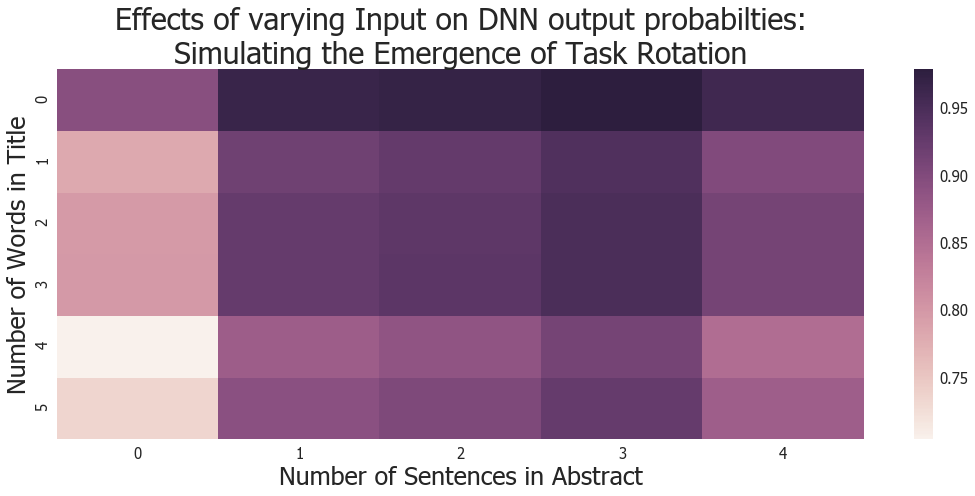

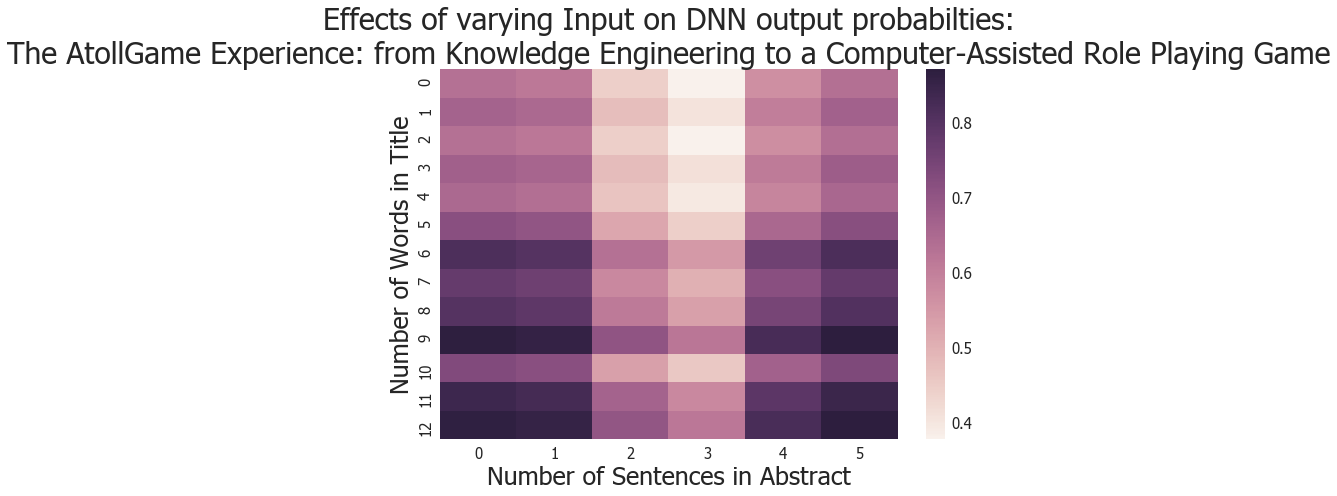

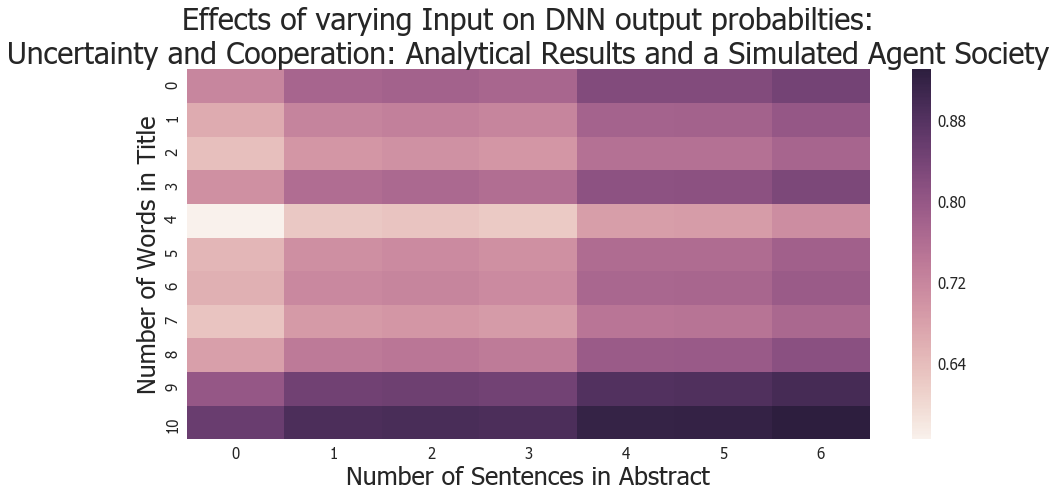

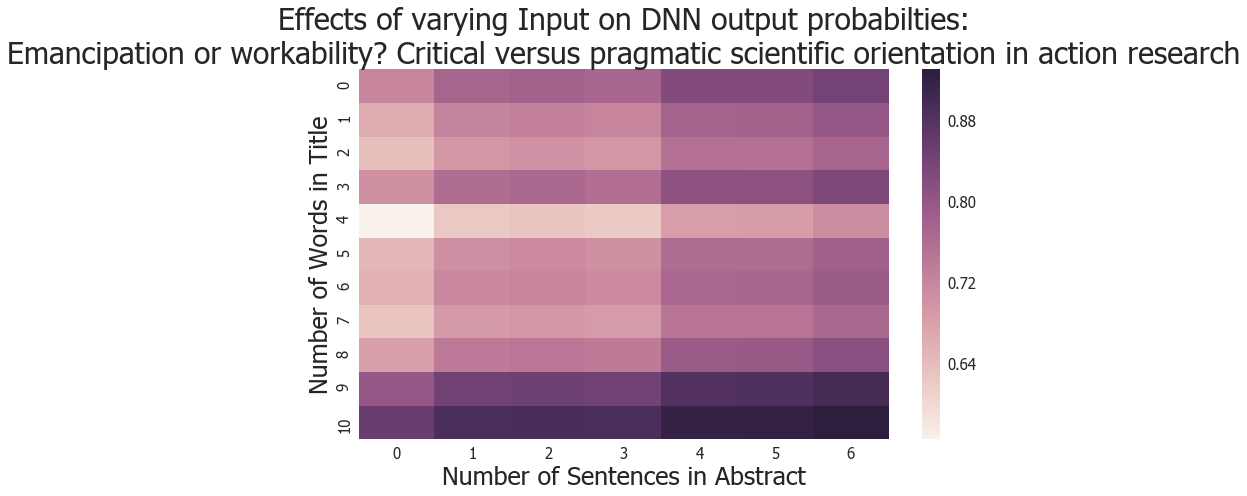

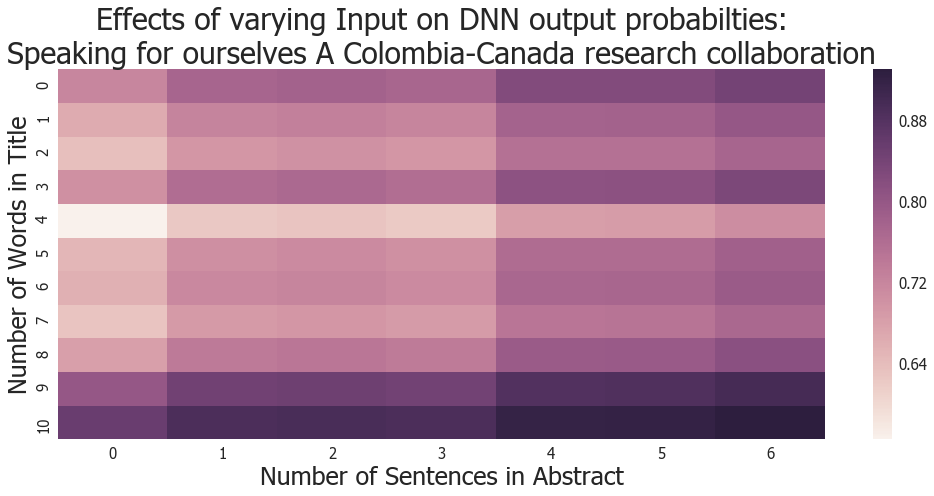

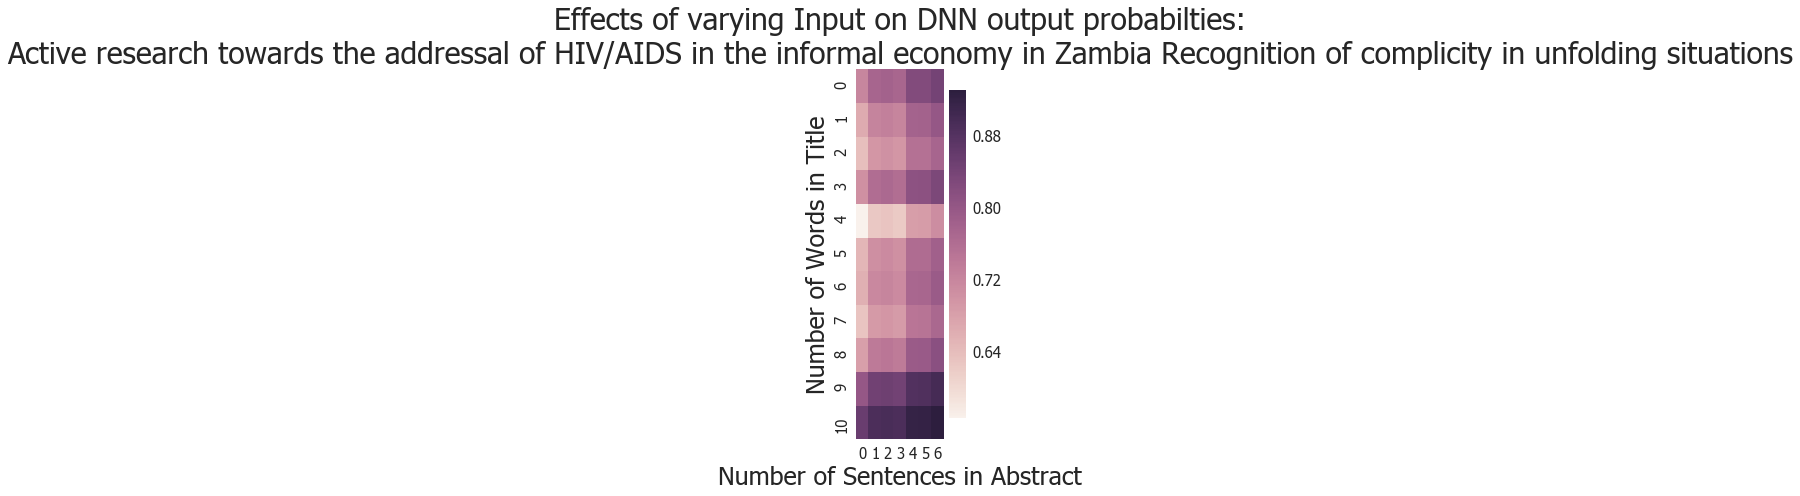

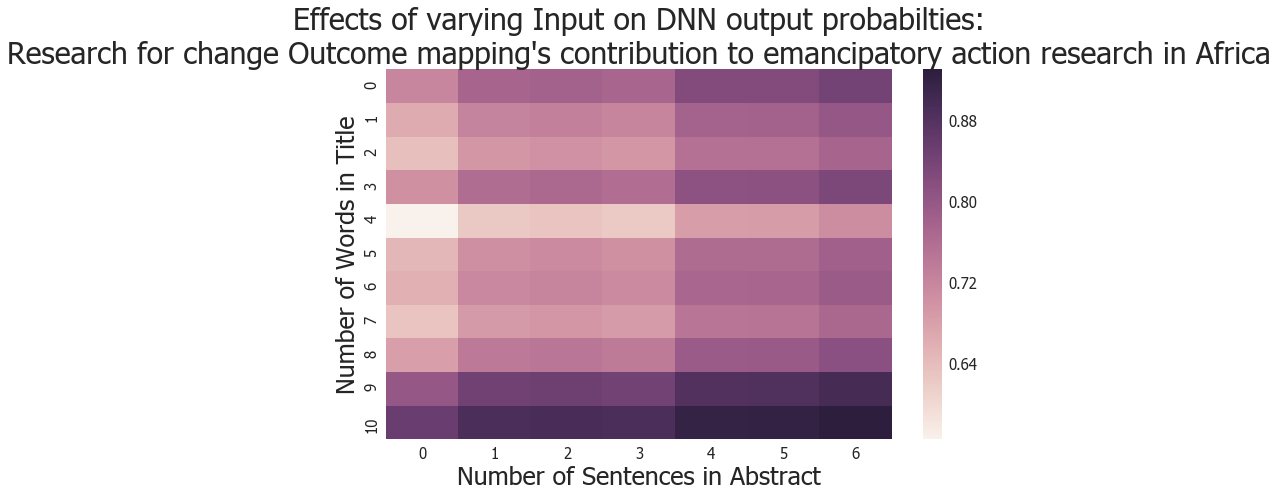

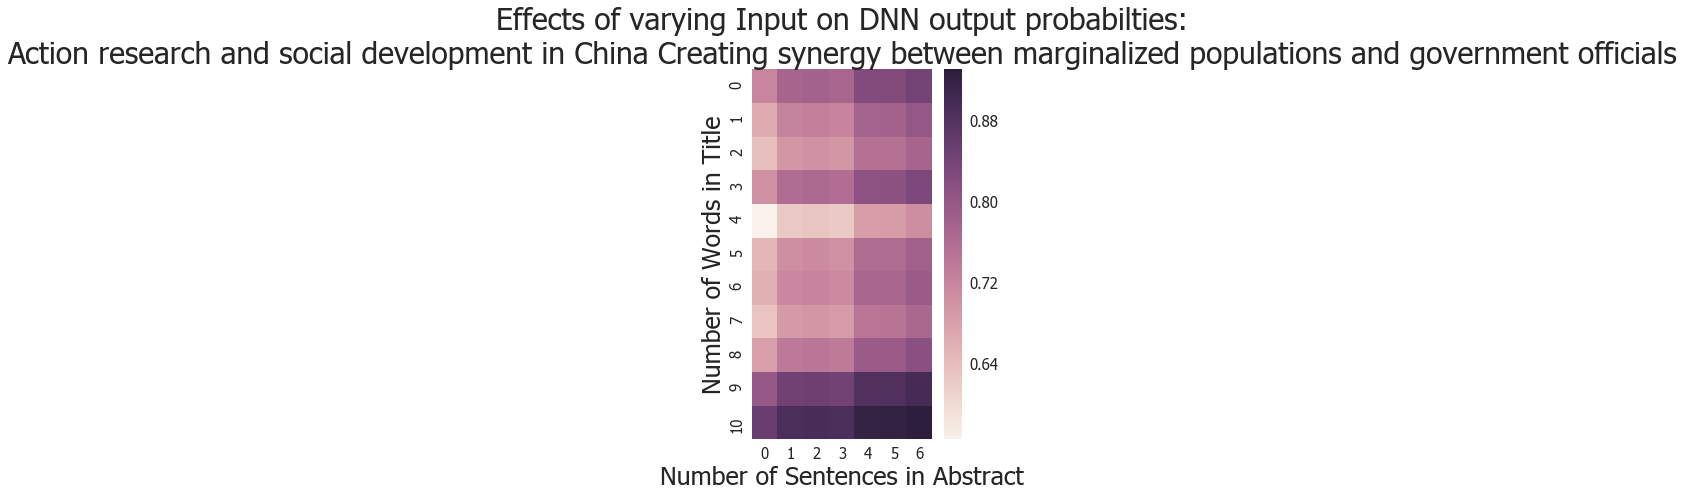

In [38]:
for i, row in df_sample.iloc[:5].iterrows():
    print(row['title'])
    row_dict = dict(row)
    row_dict['title_tokens'] = Tokens[row_dict['wos_id']][0]
    row_dict['abstract_tokens'] = Tokens[row_dict['wos_id']][1]
    predA = makeVaryingArray(row_dict, Net, w2v)
    fig, ax = plt.subplots(figsize = (15, 7))
    seaborn.heatmap(predA, ax = ax)
    ax.set_ylabel('Number of Words in Title')
    ax.set_xlabel('Number of Sentences in Abstract')
    ax.set_title("Effects of varying Input on DNN output probabilties:\n{}".format(row['title']))
    fig.tight_layout()
    plt.savefig('images/pred_var_{}.pdf'.format(row['title'][:50].replace(' ', '_')), format = 'pdf')
    
for i, row in df_sample.iloc[-5:].iterrows():
    print(row['title'])
    predA = makeVaryingArray(row_dict, Net, w2v)
    fig, ax = plt.subplots(figsize = (15, 7))
    seaborn.heatmap(predA, ax = ax)
    ax.set_ylabel('Number of Words in Title')
    ax.set_xlabel('Number of Sentences in Abstract')
    ax.set_title("Effects of varying Input on DNN output probabilties:\n{}".format(row['title']))
    fig.tight_layout()
    plt.savefig('images/pred_var_{}.pdf'.format(row['title'][:50].replace(' ', '_').replace('/', '')), format = 'pdf')

# Next steps

+ Get interface with R setup
+ Make interactive
+ Add real explanations
+ Maybe add more modes

Is it truthful?

Is it functional?

Is it beautiful?

Is it insightful?

Is it enlightening?